In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# <span style="color:purple"> LEITURA DATASET </span>

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,classe,signer
0,-0.015155,0.083723,-0.019764,0.016621,0.067022,-0.016464,0.037898,0.040288,-0.018105,0.048381,...,-0.013157,-0.029493,-0.019044,0.004893,-0.044368,-0.022143,0.026663,-0.034211,a,0.0
1,-0.017470,0.089129,-0.024697,0.017672,0.070180,-0.018930,0.037136,0.042391,-0.020137,0.047958,...,-0.013763,-0.033332,-0.020168,0.004791,-0.048958,-0.022997,0.025612,-0.040157,a,0.0
2,-0.018608,0.088464,-0.034686,0.017341,0.069314,-0.027479,0.036115,0.041589,-0.026058,0.046782,...,-0.015631,-0.034420,-0.021920,0.002710,-0.050564,-0.024800,0.022225,-0.041706,a,0.0
3,-0.018881,0.089806,-0.033932,0.017604,0.069527,-0.027086,0.036691,0.042036,-0.025525,0.047545,...,-0.016675,-0.034124,-0.021750,0.000277,-0.050739,-0.023401,0.019764,-0.042837,a,0.0
4,-0.018110,0.088998,-0.032207,0.016747,0.068922,-0.024993,0.036877,0.042021,-0.023326,0.047667,...,-0.015065,-0.034571,-0.020478,0.001885,-0.050963,-0.022766,0.021520,-0.041488,a,0.0


In [3]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'y']

In [4]:
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [5]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,classe,signer
0,-0.015155,0.083723,-0.019764,0.016621,0.067022,-0.016464,0.037898,0.040288,-0.018105,0.048381,...,-0.013157,-0.029493,-0.019044,0.004893,-0.044368,-0.022143,0.026663,-0.034211,a,0.0
1,-0.017470,0.089129,-0.024697,0.017672,0.070180,-0.018930,0.037136,0.042391,-0.020137,0.047958,...,-0.013763,-0.033332,-0.020168,0.004791,-0.048958,-0.022997,0.025612,-0.040157,a,0.0
2,-0.018608,0.088464,-0.034686,0.017341,0.069314,-0.027479,0.036115,0.041589,-0.026058,0.046782,...,-0.015631,-0.034420,-0.021920,0.002710,-0.050564,-0.024800,0.022225,-0.041706,a,0.0
3,-0.018881,0.089806,-0.033932,0.017604,0.069527,-0.027086,0.036691,0.042036,-0.025525,0.047545,...,-0.016675,-0.034124,-0.021750,0.000277,-0.050739,-0.023401,0.019764,-0.042837,a,0.0
4,-0.018110,0.088998,-0.032207,0.016747,0.068922,-0.024993,0.036877,0.042021,-0.023326,0.047667,...,-0.015065,-0.034571,-0.020478,0.001885,-0.050963,-0.022766,0.021520,-0.041488,a,0.0


In [18]:
X = np.array(dataset.iloc[:,:63])
Y = np.array(le.transform(dataset['classe']))
Y = tf.keras.utils.to_categorical(Y, len(classes))

In [19]:
idx1 = dataset[dataset['signer'] == 0].index
idx2 = dataset[dataset['signer'] == 1].index

In [20]:
X_train = X[idx1]
Y_train = Y[idx1]

X_test = X[idx2]
Y_test = Y[idx2]

In [21]:
X_train.shape, X_test.shape

((2783, 63), (398, 63))

# <span style="color:purple"> MODELO </span>

In [22]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation='relu', input_shape=(63,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(21, activation='softmax'),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2048      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 21)                2709      
                                                                 
Total params: 15,189
Trainable params: 15,189
Non-traina

In [24]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
35/35 [==============================] - 0s 4ms/step - loss: 0.0175 - accuracy: 0.9960 - val_loss: 30.3744 - val_accuracy: 0.0646
Epoch 2/40
35/35 [==============================] - 0s 4ms/step - loss: 0.0161 - accuracy: 0.9960 - val_loss: 30.3234 - val_accuracy: 0.0952
Epoch 3/40
35/35 [==============================] - 0s 4ms/step - loss: 0.0181 - accuracy: 0.9955 - val_loss: 30.5908 - val_accuracy: 0.0754
Epoch 4/40
35/35 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9969 - val_loss: 31.0680 - val_accuracy: 0.0610
Epoch 5/40
35/35 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9973 - val_loss: 30.8758 - val_accuracy: 0.0862
Epoch 6/40
35/35 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 31.2798 - val_accuracy: 0.0664
Epoch 7/40
35/35 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9946 - val_loss: 31.2958 - val_accuracy: 0.0736
Epoch 8/40
35

In [16]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 0s 2ms/step - loss: 6.9487 - accuracy: 0.6281


[6.948714733123779, 0.6281406879425049]

<AxesSubplot:>

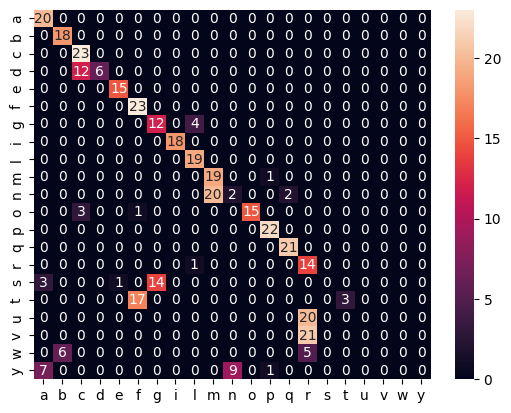

In [17]:
pred = model.predict(X_test)
labels = [np.argmax(y) for y in Y_test]
predictions = [np.argmax(x) for x in pred]
cm = confusion_matrix(labels, predictions)

df_cm = pd.DataFrame(np.array(cm), index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt=".0f")